In [1]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import jovian

<IPython.core.display.Javascript object>

In [2]:
dataset = MNIST(root='data/', download=True, train=True, transform=transforms.ToTensor())

In [3]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


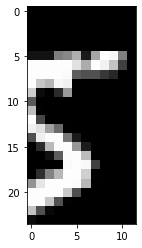

In [4]:
plt.imshow(img_tensor[0, 0:24, 13:25], cmap='gray') #needs 1st part as 0, channel not expected by imshow or is the last dimension

In [5]:
train_ds, val_ds = random_split(dataset, [50000, 10000])

batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size, shuffle=True)

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [19]:
input_size = 28*28
num_classes = 10

class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, input_size)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
         images, labels = batch
         out = self(images)
         loss = F.cross_entropy(out, labels)
         acc = accuracy(out, labels)
         return {"val_loss": loss, "val_acc": acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accuracies = [x['val_acc'] for x in outputs]
        epoch_accuracy = torch.stack(batch_accuracies).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_accuracy.item()}
    
    def epoch_end(self, epoch, result):
        print('Epoch {0}: Validation Loss: {1}, Validation Accuracy: {2}'.format(epoch, result['val_loss'], result['val_acc'])) 

model = MnistModel()

In [24]:
def evaluate(model, val_loader):
    val_outs = [model.validation_step(val_batch) for val_batch in val_loader]
    val_result = model.validation_epoch_end(val_outs)
    return val_result

In [25]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = []
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        val_result = evaluate(model, val_loader)
        model.epoch_end(epoch, val_result)
        history.append(val_result)
    return history

In [26]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch 0: Validation Loss: 1.1116691827774048, Validation Accuracy: 0.8148733973503113
Epoch 1: Validation Loss: 1.0387887954711914, Validation Accuracy: 0.8222903609275818
Epoch 2: Validation Loss: 0.9750680923461914, Validation Accuracy: 0.8272349834442139
Epoch 3: Validation Loss: 0.9255543947219849, Validation Accuracy: 0.8317840099334717
Epoch 4: Validation Loss: 0.8851882219314575, Validation Accuracy: 0.8360363841056824


In [28]:
history1

[{'val_loss': 1.1116691827774048, 'val_acc': 0.8148733973503113},
 {'val_loss': 1.0387887954711914, 'val_acc': 0.8222903609275818},
 {'val_loss': 0.9750680923461914, 'val_acc': 0.8272349834442139},
 {'val_loss': 0.9255543947219849, 'val_acc': 0.8317840099334717},
 {'val_loss': 0.8851882219314575, 'val_acc': 0.8360363841056824}]

In [36]:
def predict(image, model=model):
    xb = image.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

In [37]:
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

Label: 7 , Predicted: 7


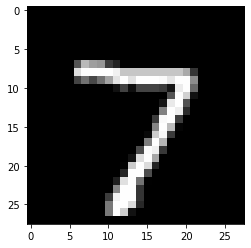

In [38]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict(img, model))

In [65]:
jovian.commit(filename='logistic_regression.ipynb',  project='pytorch_learn', git_commit=True, git_message='logistic regression final')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "nempickaxe/pytorch-learn" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Error: Failed to read Anaconda environment using command: "conda env export -n base --no-builds"
[jovian] Committed successfully! https://jovian.ml/nempickaxe/pytorch-learn


'https://jovian.ml/nempickaxe/pytorch-learn'